<a href="https://colab.research.google.com/github/Javier1224/Reconocimiento_Leucemia/blob/main/Efficientnet_3_de_Proyecto_Final.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Se cargan las librerías a utilizar durante el desarrollo del proyecto

In [2]:
from IPython import get_ipython
from IPython.display import display
# %%
import numpy as np
import matplotlib.pyplot as plt
import random
from copy import deepcopy
import os

import skimage
import skimage.color as skic # operaciones con color
from skimage.color import rgb2gray # Importar rgb2gray
import skimage.filters as skif # filtros
import skimage.util as sku # utilidades
import skimage.metrics as skm # métricas
from skimage import segmentation as seg # Segmentación
import skimage.io as skiox

from skimage.exposure import histogram
from skimage.transform import resize
from skimage import img_as_float, exposure
from skimage.feature import hog
#from skimage.feature import greycomatrix, greycoprops
from skimage import color, data, transform
from skimage.feature import canny

  # Importar skimage.io para cargar la imagen
import matplotlib.image as mpimg
import cv2


# Para poder hacer la segmentacion
from sklearn.model_selection import train_test_split


Se recupera la información de la base de datos desde el repositorio

In [3]:
!wget -q https://github.com/Javier1224/Reconocimiento_Leucemia/releases/download/Eliza/Datos.zip
!unzip -q Datos.zip

Se crean las funciones necesarias para manipular la información

In [4]:
#Funcion para mostrar la imagen
def cargar_imagenes_por_carpeta(ruta):
  images = []
  imagen_con_Tag = []
  for filename in os.listdir(ruta):
      if filename.endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp')):
          image_path = os.path.join(ruta, filename)
          image = skiox.imread(image_path)


          # Extraer etiqueta desde el nombre de archivo (hasta el primer guión bajo por ejemplo)
          label = filename.split('-')[-2]
          imagen_con_Tag.append((image,label))
          #images.append(imagen_con_Tag)
  return imagen_con_Tag


def show(img):
    fig, ax = plt.subplots(1, 1, figsize=(8, 8))
    ax.imshow(img, cmap=plt.cm.gray) # usar pyplot biultin colormap gray
    ax.set_axis_off()
    plt.show()

def show_images_side_by_side(images, names):
    num_images = len(images)
    fig, axes = plt.subplots(1, num_images, figsize=(num_images * 8, 8))

    for index, (img, name) in enumerate(zip(images, names)):
        axes[index].imshow(img, cmap=plt.cm.gray)
        axes[index].set_title(name)

    plt.show()

def linear_contrast_adjustment(image, min_intensity, max_intensity):
    # Ajusta el contraste linealmente
    adjusted_image = np.clip((image - min_intensity) * (255.0 / (max_intensity - min_intensity)), 0, 255)
    return adjusted_image.astype(np.uint8)

def showPair(image1, image2):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 5))
    ax1.imshow(image1, cmap='gray')
    ax1.axis('off')
    ax1.set_title('Imagen')
    ax2.imshow(image2, cmap='gray')
    ax2.axis('off')
    ax2.set_title('Imagen con bordes')
    plt.show()

def aplicar_espejo(imagen):
    return imagen.transpose(Image.FLIP_LEFT_RIGHT)

def crear_directorio(ruta):
    if not os.path.exists(ruta):
        os.makedirs(ruta)

Funciones para realizar data augmentation

In [5]:
# Simulación de augmentar_imagen para rotaciones y reflejos
def augmentar_imagen(imagen):
    transformacion = random.choice(['rot90', 'rot270', 'flip'])
    if transformacion == 'rot90':
        return np.rot90(imagen, k=1)
    elif transformacion == 'rot270':
        return np.rot90(imagen, k=3)
    elif transformacion == 'flip':
        return np.fliplr(imagen)
    return imagen  # En caso de fallo

# Función principal que separa y aumenta
def agrupar_etiquetas_malignas(label):
    if "Early" in label or "Pre" in label or "Pro" in label:
        return "Malignant"
    return "Benign"

# Función para separar en train/test y luego submuestrear
def procesar_con_submuestreo(carpetaRaiz):
  clases = ['Benign', 'Early', 'Pre', 'Pro']
  clases_malignas = ['Early', 'Pre', 'Pro']

  data_benign = carpetaRaiz[0]
  data_malign = carpetaRaiz[1] + carpetaRaiz[2] + carpetaRaiz[3]

  # Separar test y train por separado para cada grupo
  train_benign, test_benign = train_test_split(data_benign, test_size=0.2, random_state=42)
  train_malign, test_malign = train_test_split(data_malign, test_size=0.2, random_state=42)

  # Submuestreo: tomar el mínimo entre los dos
  min_train_samples = min(len(train_benign), len(train_malign))
  train_benign_sub = random.sample(train_benign, min_train_samples)
  train_malign_sub = random.sample(train_malign, min_train_samples)

  # Reconstruir estructura tipo carpetaRaiz
  datos_entrenamiento = [
      train_benign_sub,
      [img for img in train_malign_sub if "Early" in img[1]],
      [img for img in train_malign_sub if "Pro" in img[1]],
      [img for img in train_malign_sub if "Pre" in img[1]]
  ]

  datos_prueba = [
      test_benign,
      [img for img in test_malign if "Early" in img[1]],
      [img for img in test_malign if "Pro" in img[1]],
      [img for img in test_malign if "Pre" in img[1]]
  ]

  return datos_entrenamiento, datos_prueba

def agrupar_en_dos_clases(data_train):
    """
    Toma data_train con 4 listas (Benign, Early, Pro, Pre)
    y retorna una nueva lista con 2 listas:
    - [0]: lista de tuplas (imagen, 'Benign')
    - [1]: lista de tuplas (imagen, 'Malignant')
    """
    benignas = []
    malignas = []

    for i, clase in enumerate(data_train):
        for imagen, etiqueta in clase:
            if 'Benign' in etiqueta:
                benignas.append((imagen, 'Benign'))
            else:
                malignas.append((imagen, 'Malignant'))

    return [benignas, malignas]

def MostrarStructura(data):
  for i in range(len(data)):
    print(f"Categoría {data[i][0][1]} ahora tiene: {len(data[i])} imágenes")
  print(" ")

Ahora, se debe cargar las rutas desde las cuales cargar los datos a variables en python con las que poder trabajar

In [6]:
# Se cargar cada carpeta de imagenes en una variable en particular
Benign = "/content/Original/Benign"
Early = "/content/Original/Early"
Pro = "/content/Original/Pre"
Pre = "/content/Original/Pro"

celulas = [Benign,Early,Pro,Pre]
celulasTag = ["Benign","Early","Pro","Pre"]
carpetaRaiz = []
for ruta in celulas:
  carpetaRaiz.append(cargar_imagenes_por_carpeta(ruta))

for folder in range(len(carpetaRaiz)):
  print(f'La cantidad de imagenes de {celulasTag[folder]} es {len(carpetaRaiz[folder])}')

La cantidad de imagenes de Benign es 504
La cantidad de imagenes de Early es 985
La cantidad de imagenes de Pro es 963
La cantidad de imagenes de Pre es 804


La estructura a manejar con los datos cargados es la siguiente:


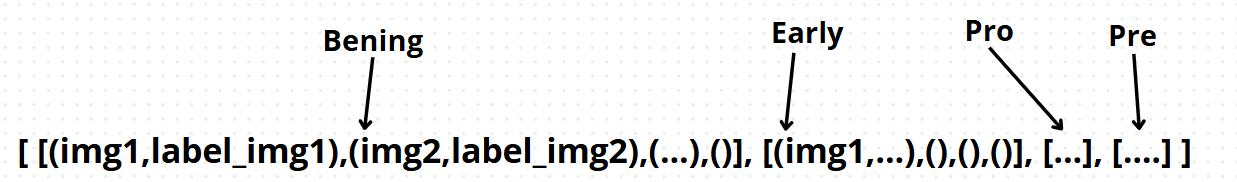

Se aplica el balanceo de carga en base a aplicar transformaciones de rotación de 90 grados y reflexión de las imágenes

In [7]:
data_Train, data_Test = procesar_con_submuestreo(carpetaRaiz)

print("Datos de entrenamiento")
MostrarStructura(data_Train)
print("Datos de prueba")
MostrarStructura(data_Test)
data_Train_1Etapa = agrupar_en_dos_clases(data_Train)
MostrarStructura(data_Train_1Etapa)

data_Test_1Etapa = agrupar_en_dos_clases(data_Test)
MostrarStructura(data_Test_1Etapa)

Datos de entrenamiento
Categoría Benign ahora tiene: 403 imágenes
Categoría Early ahora tiene: 146 imágenes
Categoría Pro ahora tiene: 110 imágenes
Categoría Pre ahora tiene: 147 imágenes
 
Datos de prueba
Categoría Benign ahora tiene: 101 imágenes
Categoría Early ahora tiene: 203 imágenes
Categoría Pro ahora tiene: 161 imágenes
Categoría Pre ahora tiene: 187 imágenes
 
Categoría Benign ahora tiene: 403 imágenes
Categoría Malignant ahora tiene: 403 imágenes
 
Categoría Benign ahora tiene: 101 imágenes
Categoría Malignant ahora tiene: 551 imágenes
 


Se define la función que hará el procesamiento de la información para una entrada de datos determinada.

In [8]:
def preprocesar_imagenes(data,SHOW):
  Preprocesada = []
  for folder in range(len(data)):
      images = data[folder]
      images_preprocesadas = []
      cant_muestras_sh = 0

      for i in range(len(images)):
          # Entrada
          img_rgb = images[i][0]
          label_img = images[i][1]

          # Convertir a HSV
          img_hsv = cv2.cvtColor(img_rgb, cv2.COLOR_RGB2HSV)

          # Segmentación por umbral HSV
          lower = np.array([120, 70, 70])
          upper = np.array([180, 255, 255])
          mask = cv2.inRange(img_hsv, lower, upper)
          segmented = cv2.bitwise_and(img_hsv, img_hsv, mask=mask)

          # Convertir a RGB para modelos preentrenados que esperan RGB
          segmented_rgb = cv2.cvtColor(segmented, cv2.COLOR_HSV2RGB)

          # Redimensionar a 224x224
          resized = cv2.resize(segmented_rgb, (224, 224), interpolation=cv2.INTER_AREA)

          # Normalización [0,1]
          normalized = resized.astype(np.float32) / 255.0

          # Agregar imagen con su etiqueta
          images_preprocesadas.append((normalized, label_img))

          # Visualizar solo las dos primeras por clase
          if SHOW == True:
            if cant_muestras_sh < 4:
                fig, axs = plt.subplots(1, 4, figsize=(10, 2.5))
                axs[0].imshow(img_rgb)
                axs[0].set_title(label_img)
                axs[1].imshow(img_hsv)
                axs[1].set_title("HSV")
                axs[2].imshow(mask, cmap='gray')
                axs[2].set_title("Máscara binaria")
                axs[3].imshow(resized)
                axs[3].set_title("Segmentado y Redimensionado")
                for ax in axs:
                    ax.axis('off')
                plt.tight_layout()
                plt.show()
            cant_muestras_sh += 1

      Preprocesada.append(tuple(images_preprocesadas))
  return Preprocesada

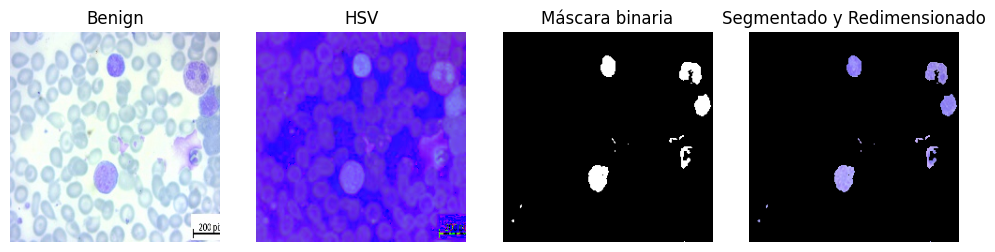

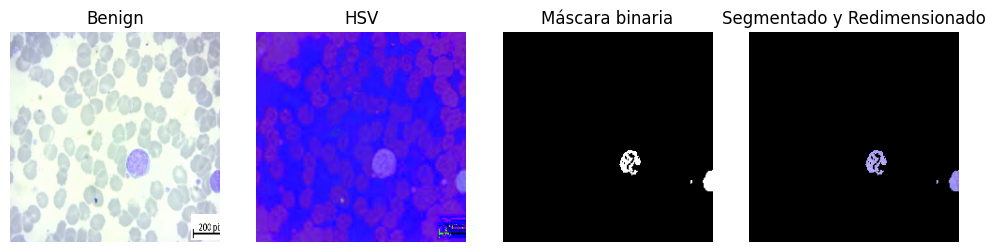

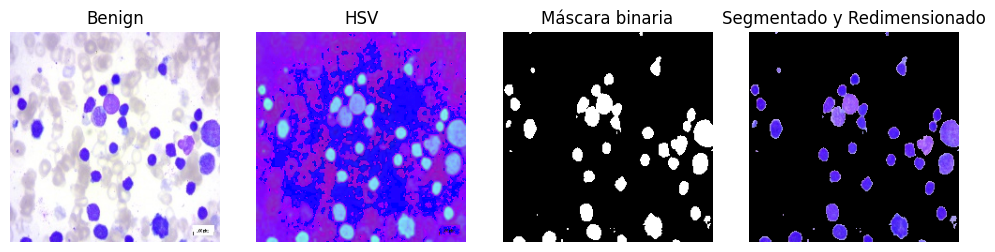

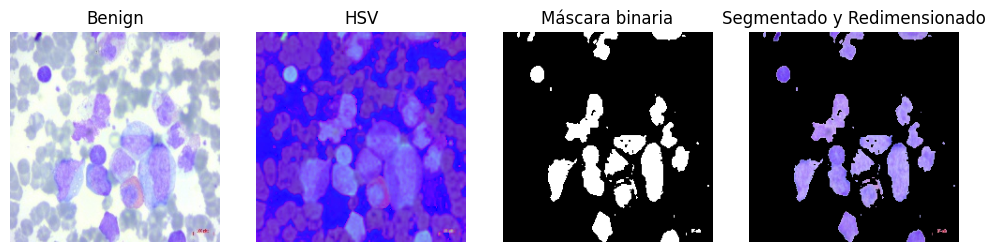

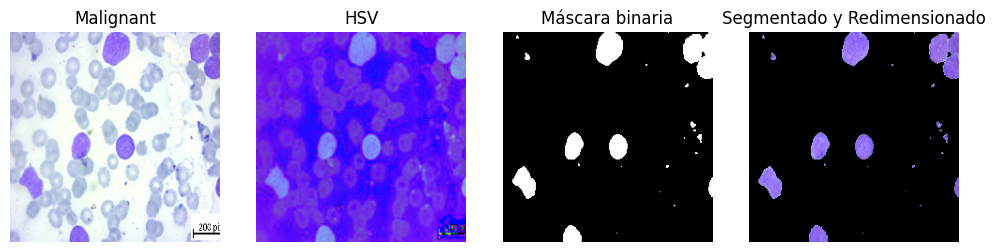

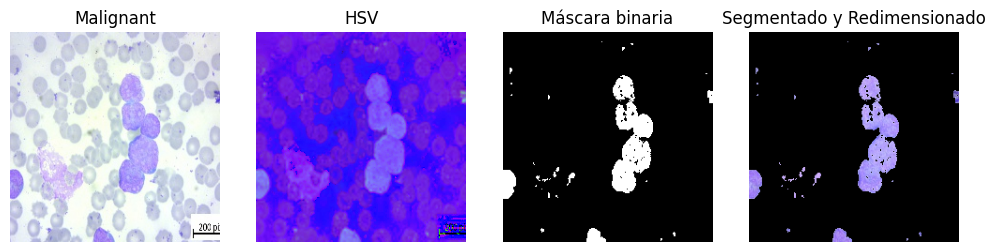

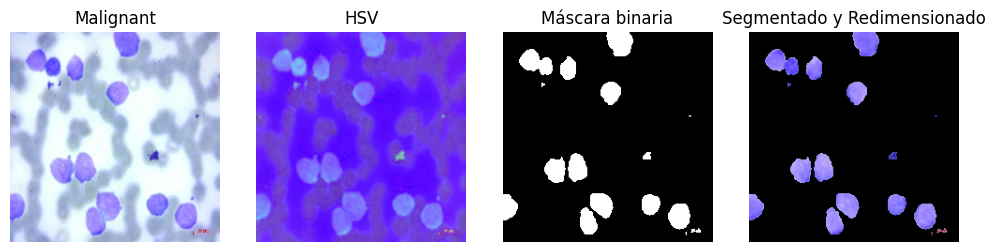

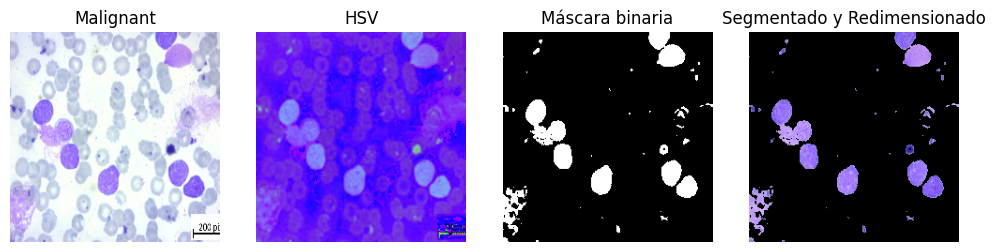

In [9]:
DataTrain_Preprocesada = preprocesar_imagenes(data_Train_1Etapa,True)
DataTest_Preprocesada = preprocesar_imagenes(data_Test_1Etapa,False)
Data_TrainPreMaligna =  preprocesar_imagenes(data_Train,False)
Data_TestPreMaligna =  preprocesar_imagenes(data_Test,False)

## Entrenamiento del modelo

Librerías necesarias para el modelo

In [10]:
import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, Flatten, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.metrics import Precision, Recall, AUC, TopKCategoricalAccuracy, CategoricalAccuracy
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

Con estas funciones se extraen y separan los datos necesarios para entrenar y probar el modelo en dos etapas, una función separa del data set entre benigno y maligno y la otra solo toma las muestras con etiqueta Early, Pro y Pre

In [11]:
def preparar_datos_para_modelo(data_preprocesada, mapa_etiquetas=None):
    imagenes = []
    etiquetas = []
    tamaño=(224, 224)

    for clase in data_preprocesada:
        for imagen, etiqueta in clase:
            # Redimensionar imagen
            imagen_resized = tf.image.resize(imagen, tamaño)
            imagenes.append(imagen_resized.numpy())  # Convertir a array NumPy
            etiquetas.append(etiqueta)

    imagenes = np.array(imagenes)

    # Crear mapa de etiquetas si no se proporciona
    if mapa_etiquetas is None:
        etiquetas_unicas = sorted(set(etiquetas))
        mapa_etiquetas = {nombre: idx for idx, nombre in enumerate(etiquetas_unicas)}

    # Convertir etiquetas a valores binarios
    etiquetas_num = np.array([mapa_etiquetas[et] for et in etiquetas])
    if len(mapa_etiquetas) > 2:
        etiquetas_num = to_categorical(etiquetas_num, num_classes=len(mapa_etiquetas))
    return imagenes, etiquetas_num, mapa_etiquetas

Se alistan los datos a trabajar en las dos etapas

In [12]:
imagenes_train, etiquetas_train, mapa_etiquetas = preparar_datos_para_modelo(DataTrain_Preprocesada)
imagenes_test, etiquetas_test, _ = preparar_datos_para_modelo(DataTest_Preprocesada, mapa_etiquetas)

imagenes_train2E, etiquetas_train2E, mapa_etiquetas2E = preparar_datos_para_modelo(Data_TrainPreMaligna[1:])
imagenes_test2E, etiquetas_test2E, _ = preparar_datos_para_modelo(Data_TestPreMaligna[1:], mapa_etiquetas2E)

In [13]:
def graficar_metricas(historia):
    metricas = ['accuracy', 'loss', 'precision', 'recall', 'auc', 'top_k_categorical_accuracy']

    for metrica in metricas:
        if metrica in historia.history:
            plt.figure(figsize=(6, 4))
            plt.plot(historia.history[metrica], label=f'Train {metrica}')
            plt.plot(historia.history['val_' + metrica], label=f'Val {metrica}')
            plt.xlabel('Epochs')
            plt.ylabel(metrica)
            plt.title(f'Evolución de {metrica}')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

Se entrena el modelo para la primera etapa para clasificación entre Benigno y Maligno

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 329s 11s/step - accuracy: 0.6343 - auc: 0.6663 - loss: 0.6440 - precision: 0.6796 - val_accuracy: 0.1549 - val_auc: 0.6463 - val_loss: 0.7790 - val_precision: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 2/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 311s 12s/step - accuracy: 0.8186 - auc: 0.9063 - loss: 0.4270 - precision: 0.8404 - val_accuracy: 0.1549 - val_auc: 0.5894 - val_loss: 0.7198 - val_precision: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 3/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 268s 10s/step - accuracy: 0.8986 - auc: 0.9610 - loss: 0.2795 - precision: 0.9037 - val_accuracy: 0.1549 - val_auc: 0.5521 - val_loss: 0.7309 - val_precision: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 4/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 286s 11s/step - accuracy: 0.9395 - auc: 0.9834 - loss: 0.1937 - precision: 0.9280 - val_accuracy: 0.1549 - val_auc: 0.4222 - val_loss: 0.7910 - val_precision: 0.0000e+00 - learning_rate: 1.0000e-04
Epoch 5/50
26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 9s/step - accur

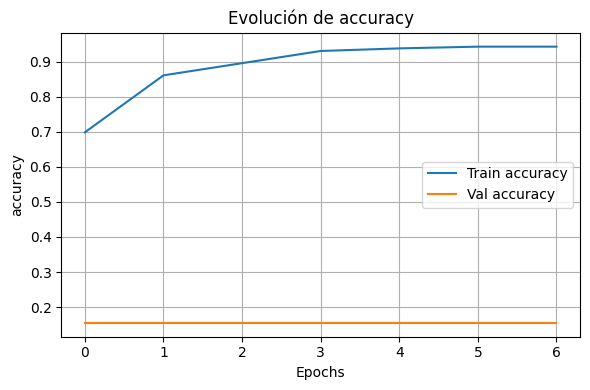

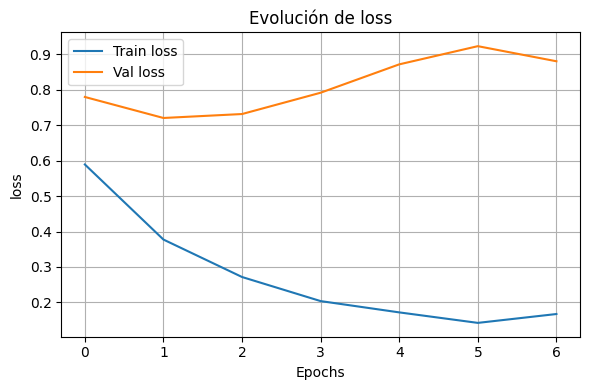

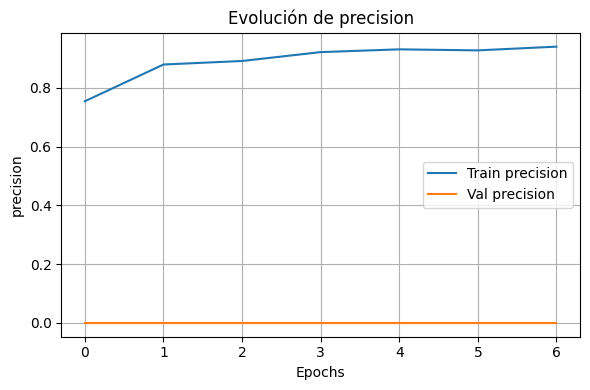

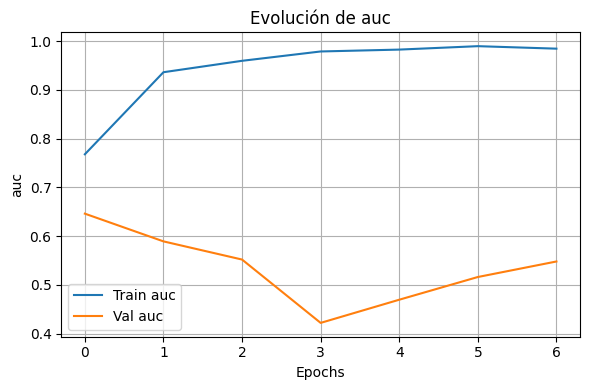

loss: 0.7198
compile_metrics: 0.1549


In [19]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Precision, AUC
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import matplotlib.pyplot as plt

# PASO 1 - Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

# PASO 2 - Modelo
base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Fine-tune solo las últimas capas
for layer in base_model.layers[-20:]:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
output = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=output)

model.compile(
    optimizer=Adam(learning_rate=1e-4),
    loss='binary_crossentropy',
    metrics=['accuracy', Precision(name='precision'), AUC(name='auc')]
)

# Callbacks
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True, verbose=1)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, min_lr=1e-6, verbose=1)

# Entrenamiento
history = model.fit(
    datagen.flow(imagenes_train, etiquetas_train, batch_size=32),
    validation_data=(imagenes_test, etiquetas_test),
    epochs=50,
    callbacks=[early_stop, reduce_lr],
    verbose=1
)

# Graficar
def graficar_metricas(historia):
    metricas = ['accuracy', 'loss', 'precision', 'auc']
    for metrica in metricas:
        if metrica in historia.history:
            plt.figure(figsize=(6, 4))
            plt.plot(historia.history[metrica], label=f'Train {metrica}')
            plt.plot(historia.history['val_' + metrica], label=f'Val {metrica}')
            plt.xlabel('Epochs')
            plt.ylabel(metrica)
            plt.title(f'Evolución de {metrica}')
            plt.legend()
            plt.grid(True)
            plt.tight_layout()
            plt.show()

graficar_metricas(history)

# Evaluar
results = model.evaluate(imagenes_test, etiquetas_test, verbose=0)
for name, value in zip(model.metrics_names, results):
    print(f"{name}: {value:.4f}")

Para la segunda etapa

Cambios para ver mejorias en la segunda etapa utilizando EfficientNet

In [15]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
from sklearn.model_selection import train_test_split
import numpy as np
import tensorflow as tf

# ------------------------------------------------------
# 1. Dividir el train en subtrain y validation
# ------------------------------------------------------

# Si tus etiquetas están one-hot:
y_train_classes = np.argmax(etiquetas_train2E, axis=1)

# Split conservando proporciones
X_train, X_val, y_train, y_val = train_test_split(
    imagenes_train2E,
    etiquetas_train2E,
    test_size=0.2,                # o el porcentaje que prefieras
    random_state=42,
    stratify=y_train_classes
)

print("X_train shape:", X_train.shape)
print("X_val shape:", X_val.shape)

# ------------------------------------------------------
# 2. Data augmentation
# ------------------------------------------------------

datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    horizontal_flip=True
)

# ------------------------------------------------------
# 3. Preprocesar validation set
# ------------------------------------------------------

X_val_prep = tf.keras.applications.efficientnet.preprocess_input(X_val)

# ------------------------------------------------------
# 4. Crear el modelo
# ------------------------------------------------------

base_model = EfficientNetB0(
    weights='imagenet',
    include_top=False,
    input_shape=(224, 224, 3)
)

# Descongelar TODO
for layer in base_model.layers:
    layer.trainable = True

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.3)(x)
predictions = Dense(
    3,
    activation='softmax'
)(x)

model = Model(inputs=base_model.input, outputs=predictions)

# SGD optimizer
optimizer = SGD(
    learning_rate=1e-3,
    momentum=0.9,
    nesterov=True
)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

# ------------------------------------------------------
# 5. Class weights
# ------------------------------------------------------

y_train_classes_split = np.argmax(y_train, axis=1)
classes = np.unique(y_train_classes_split)

class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_classes_split
)
class_weights = dict(zip(classes, class_weights))
print("Class weights:", class_weights)

# ------------------------------------------------------
# 6. Callbacks
# ------------------------------------------------------

early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=10,
    restore_best_weights=True
)

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',
    factor=0.5,
    patience=4,
    min_lr=1e-7,
    verbose=1
)

# ------------------------------------------------------
# 7. Entrenamiento
# ------------------------------------------------------

history = model.fit(
    datagen.flow(X_train, y_train, batch_size=32),
    validation_data=(X_val_prep, y_val),
    epochs=50,
    class_weight=class_weights,
    callbacks=[early_stopping, reduce_lr]
)

# ------------------------------------------------------
# 8. (Opcional) Evaluar en test después del entrenamiento
# ------------------------------------------------------

# Preparar test si lo quieres usar después:
imagenes_test2E_prep = tf.keras.applications.efficientnet.preprocess_input(imagenes_test2E)

# Solo evalúas en test cuando estés listo:
# results = model.evaluate(imagenes_test2E_prep, etiquetas_test2E)
# print("Test loss:", results[0])
# print("Test accuracy:", results[1])


X_train shape: (322, 224, 224, 3)
X_val shape: (81, 224, 224, 3)
Class weights: {np.int64(0): np.float64(0.9096045197740112), np.int64(1): np.float64(0.9333333333333333), np.int64(2): np.float64(1.205992509363296)}


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 135s 9s/step - accuracy: 0.3135 - loss: 1.1306 - val_accuracy: 0.3580 - val_loss: 1.1042 - learning_rate: 0.0010
Epoch 2/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 93s 8s/step - accuracy: 0.5524 - loss: 0.9183 - val_accuracy: 0.2716 - val_loss: 1.1059 - learning_rate: 0.0010
Epoch 3/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 94s 9s/step - accuracy: 0.7586 - loss: 0.7136 - val_accuracy: 0.2716 - val_loss: 1.1263 - learning_rate: 0.0010
Epoch 4/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 142s 9s/step - accuracy: 0.8464 - loss: 0.5740 - val_accuracy: 0.2716 - val_loss: 1.1380 - learning_rate: 0.0010
Epoch 5/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8820 - loss: 0.4771
Epoch 5: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
11/11 ━━━━━━━━━━━━━━━━━━━━ 92s 8s/step - accuracy: 0.8822 - loss: 0.4751 - val_accuracy: 0.2716 - val_loss: 1.1384 - learning_rate: 0.0010
Epoch 6/50
11/11 ━━━━━━━━━━━━━━━━━━━━ 93s 8s/step - accuracy: 0.9152 - loss: 0.3659 - val_accuracy: 

Se grafican los resultados obtenidos

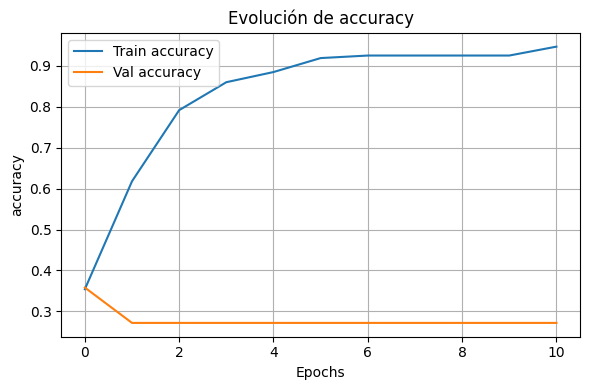

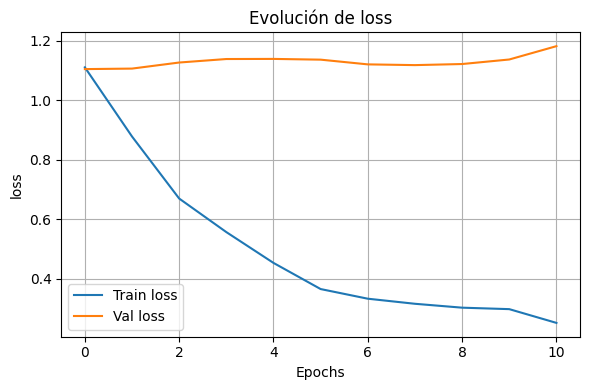

In [16]:
graficar_metricas(history)

Se realiza una busqueda de malla para encontrar los mejores resultados entre diversos parámetros

In [ ]:
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils.class_weight import compute_class_weight
import numpy as np
import tensorflow as tf

# Preprocesamiento de los datos
datagen = ImageDataGenerator(
    preprocessing_function=tf.keras.applications.efficientnet.preprocess_input,
    horizontal_flip=True
)
imagenes_test2E_prep = tf.keras.applications.efficientnet.preprocess_input(imagenes_test2E)

# Pesos balanceados
y_train_classes = np.argmax(etiquetas_train2E, axis=1)
classes = np.unique(y_train_classes)
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=classes,
    y=y_train_classes
)
class_weights = dict(zip(classes, class_weights))

# Callbacks
def get_callbacks():
    return [
        EarlyStopping(monitor='val_accuracy', patience=10, restore_best_weights=True, verbose=1),
        ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=4, min_lr=1e-7, verbose=1)
    ]

# Combinaciones de hiperparámetros
capas_congeladas_opciones = [0, 50, 100]
neuronas_densa_opciones = [64, 128, 256]
dropout_opciones = [0.3, 0.5]
learning_rates = [1e-3, 5e-4, 1e-4]

# Resultados
mejor_accuracy = 0
mejor_modelo = None
mejores_params = {}

# Grid search
for freeze_layers in capas_congeladas_opciones:
    for neuronas_densa in neuronas_densa_opciones:
        for dropout_rate in dropout_opciones:
            for lr in learning_rates:
                print(f"\nEntrenando con: freeze_layers={freeze_layers}, neuronas_densa={neuronas_densa}, dropout={dropout_rate}, lr={lr}")

                # Base model
                base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
                for i, layer in enumerate(base_model.layers):
                    layer.trainable = i >= freeze_layers

                # Clasificador
                x = base_model.output
                x = GlobalAveragePooling2D()(x)
                x = Dropout(dropout_rate)(x)
                output = Dense(3, activation='softmax')(x)

                model = Model(inputs=base_model.input, outputs=output)

                model.compile(
                    optimizer=SGD(learning_rate=lr, momentum=0.9, nesterov=True),
                    loss='categorical_crossentropy',
                    metrics=['accuracy']
                )

                # Entrenamiento
                history = model.fit(
                    datagen.flow(imagenes_train2E, etiquetas_train2E, batch_size=32),
                    validation_data=(imagenes_test2E_prep, etiquetas_test2E),
                    epochs=50,
                    class_weight=class_weights,
                    callbacks=get_callbacks(),
                    verbose=1
                )

                val_acc = max(history.history['val_accuracy'])
                print(f"Mejor val_accuracy en esta configuración: {val_acc:.4f}")

                if val_acc > mejor_accuracy:
                    mejor_accuracy = val_acc
                    mejor_modelo = model
                    mejores_params = {
                        'freeze_layers': freeze_layers,
                        'neuronas_densa': neuronas_densa,
                        'dropout': dropout_rate,
                        'learning_rate': lr
                    }
                #graficar_metricas(history)

# Resultado final
print("\nMejores hiperparámetros encontrados:")
print(mejores_params)
print(f"Mejor val_accuracy: {mejor_accuracy:.4f}")


Entrenando con: freeze_layers=0, neuronas_densa=64, dropout=0.3, lr=0.001
16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


13/13 ━━━━━━━━━━━━━━━━━━━━ 203s 13s/step - accuracy: 0.4465 - loss: 1.0967 - val_accuracy: 0.4265 - val_loss: 1.1486 - learning_rate: 0.0010
Epoch 2/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 164s 13s/step - accuracy: 0.7320 - loss: 0.8412 - val_accuracy: 0.3394 - val_loss: 1.1033 - learning_rate: 0.0010
Epoch 3/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 162s 13s/step - accuracy: 0.8420 - loss: 0.6317 - val_accuracy: 0.3394 - val_loss: 1.1102 - learning_rate: 0.0010
Epoch 4/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 231s 15s/step - accuracy: 0.8929 - loss: 0.4980 - val_accuracy: 0.3394 - val_loss: 1.1222 - learning_rate: 0.0010
Epoch 5/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 149s 12s/step - accuracy: 0.8848 - loss: 0.4106 - val_accuracy: 0.3376 - val_loss: 1.1212 - learning_rate: 0.0010
Epoch 6/50
13/13 ━━━━━━━━━━━━━━━━━━━━ 0s 8s/step - accuracy: 0.8874 - loss: 0.3463
Epoch 6: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
13/13 ━━━━━━━━━━━━━━━━━━━━ 139s 11s/step - accuracy: 0.8871 - loss: 0.3466 - val_accuracy: 0